In [271]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
import venn
from scipy import stats
from statsmodels.stats import anova
import scikit_posthocs as sp
import upsetplot 
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")

In [272]:
PXD002516 = pd.read_csv('/home/robbe/ionbot/Voor_vergelijking_OSE/From_scratch/PXD002516_formatted.tsv', sep="\t")

In [273]:
PXD002516["ionbotID"] = PXD002516["Scan"].astype(str) + PXD002516["ionbot Sequence"] + PXD002516["ionbot_mods_formatted"].astype(str)
PXD002516["FraggerID"] = PXD002516["Scan"].astype(str) + PXD002516["Fragger Sequence"] + PXD002516["fragger_mods_formatted"].astype(str)
PXD002516["pFindID"] = PXD002516["Scan"].astype(str) + PXD002516["pFind Sequence"] + PXD002516["pfind_mods_formatted"].astype(str)
PXD002516["CometID"] = PXD002516["Scan"].astype(str) + PXD002516["Comet Raw Sequence"] + PXD002516["comet_mods_formatted"].astype(str)

In [274]:
PXD002516["Comet Raw Sequence"].mask(PXD002516["Comet q-value"] > 0.01, np.nan, inplace=True)

In [275]:
PXD002516["Fragger PEP"] = 1 - PXD002516["Fragger Probability"]

In [276]:
def eval_similarities(row):
    ionbotseq = str(row['ionbot Sequence'])
    fraggerseq = str(row["Fragger Sequence"])
    pfindseq = str(row["pFind Sequence"])
    cometseq = str(row['Comet Raw Sequence'])

    ionbotmods = str(row["ionbot_mods_formatted"])
    fraggermods = str(row["fragger_mods_formatted"])
    pfindmods = str(row["pfind_mods_formatted"])
    cometmods = str(row["comet_mods_formatted"])

    ionbot = ionbotseq + ionbotmods
    fragger = fraggerseq + fraggermods
    pfind = pfindseq + pfindmods
    comet = cometseq + cometmods

    def ionbotex(ionbotseq):
        if ionbotseq == "nan":
            return "0"
        else:
            return "1"
    
    def fraggerex(fraggerseq):
        if fraggerseq == "nan":
            return "0"
        else: 
            return "1"

    def pfindex(pfindseq):
        if pfindseq == "nan":
            return "0"
        else:
            return "1"

    def cometex(cometseq):
        if cometseq == "nan":
            return "0"
        else: 
            return "1"
            
    def ionbotfragger(ionbot, fragger):
        if ionbot == fragger:
            return "1"
        else:
            return "0"
    def ionbotpfind(ionbot,pfind):
        if ionbot == pfind:
            return "1"
        else:
            return "0"

    def ionbotcomet(ionbot, comet):
        if ionbot == comet:
            return "1"
        else:
            return "0"
    
    def fraggerpfind(fragger, pfind):
        if fragger == pfind:
            return "1"
        else:
            return "0"
    
    def fraggercomet(fragger,comet):
        if fragger == comet:
            return "1"
        else:
            return "0"
    
    def pfindcomet(pfind, comet):
        if pfind == comet:
            return "1"
        else:
            return "0"
    
    code = ionbotex(ionbotseq) + fraggerex(fraggerseq) + pfindex(pfindseq) + cometex(cometseq) + "-" + ionbotfragger(ionbot, fragger) + ionbotpfind(ionbot, pfind) + ionbotcomet(ionbot, comet) + fraggerpfind(fragger, pfind) + fraggercomet(fragger, comet) + pfindcomet(pfind, comet)
    return code

In [277]:
PXD002516["code"] = PXD002516.progress_apply(eval_similarities, axis=1)

100%|██████████| 547414/547414 [00:40<00:00, 13364.60it/s]


In [278]:
ionbotPSM = set(PXD002516.index[PXD002516['ionbot Sequence'].notna()].tolist())
fraggerPSM = set(PXD002516.index[PXD002516['Fragger Sequence'].notna()].tolist())
pfindPSM = set(PXD002516.index[PXD002516["pFind Sequence"].notna()].tolist())
cometPSM = set(PXD002516.index[PXD002516["Comet Raw Sequence"].notna()].tolist())
setlist = [ionbotPSM, fraggerPSM, pfindPSM, cometPSM]

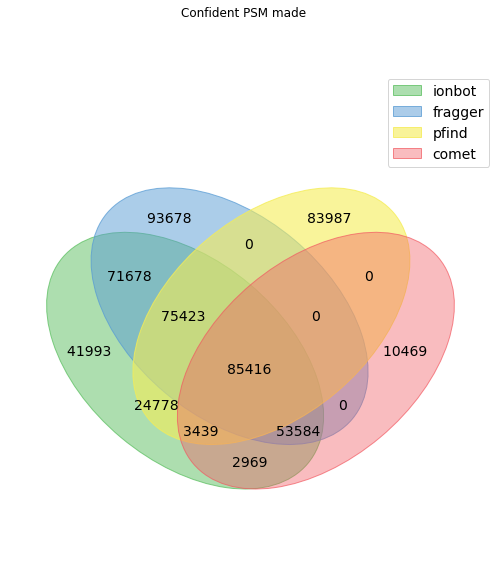

In [279]:
labels = venn.get_labels(setlist)
fig, ax = venn.venn4(labels, names=['ionbot', 'fragger', 'pfind', 'comet'])
fig.suptitle("Confident PSM made")
fig.show()

In [280]:
def evalseq(row, SE="ionbot"):
    if row["{} Sequence".format(SE)] == row["Comet Raw Sequence"]:
        return True
    else:
        return False

In [281]:
def evalmod(row, SE="ionbot"):
    if pd.isna(row["comet_mods_formatted"]):
        if not pd.isna(row["{}_mods_formatted".format(SE)]): #If comet doesn't give mods but OSE does
            return "Newly modified"
        else:                                                #If both comet and OSE dont give mods
            return "Remains unmodified"
    else:
        if not pd.isna(row["{}_mods_formatted".format(SE)]): #If comet gives mods and OSE gives mods
            if row["{}_mods_formatted".format(SE)] == row["comet_mods_formatted"]:
                return "Same modifications"
            else:
                return "Different modifications"
        else:
            return "No longer modified"

In [282]:
PXD002516["ionbot_seq_eval"] = PXD002516.apply(evalseq, SE="ionbot", axis=1)
PXD002516["fragger_seq_eval"] = PXD002516.apply(evalseq, SE="Fragger", axis=1)
PXD002516["pfind_seq_eval"] = PXD002516.apply(evalseq, SE="pFind", axis=1)

In [283]:
PXD002516["ionbot_mods_eval"] = PXD002516.apply(evalmod, SE="ionbot", axis=1)
PXD002516["fragger_mods_eval"] = PXD002516.apply(evalmod, SE="fragger", axis=1)
PXD002516["pfind_mods_eval"] = PXD002516.apply(evalmod, SE="pfind", axis=1)

==> welke spectra hebben confident PSM voor de search engines

In [284]:
Allmatched = PXD002516[PXD002516["code"].str.startswith("1111-")]

In [285]:
codedict = {"1111-111111" : "Same for all 4", "1111-101010" : "pFind deviates", "1111-110100" : "Comet deviates", "1111-000111": "ionbot deviates", "1111-011001" : "MSFragger deviates", "1111-000100" : "MSFragger & pFind agree, ionbot and Comet differ", "1111-010010": "ionbot = pFind & MSFragger = Comet", "1111-000001" : "pFind and Comet agree, ionbot and MSFragger differ", "1111-010000" : "ionbot and pFind agree, MSFragger and Comet differ", "1111-000000" : "Different for all 4", "1111-001000" : "ionbot and Comet agree, MSFragger and pFind differ", "1111-100001" : "ionbot = MSFragger & pFind = Comet", "1111-000010":"MSFragger and Comet agree, pFind and ionbot differ", "1111-100000" : "ionbot and MSFragger agree, pFind and Comet differ", "1111-001100" : "ionbot = Comet & MSFragger = pFind"}

In [286]:
Allmatched.replace({"code" : codedict}, inplace=True)

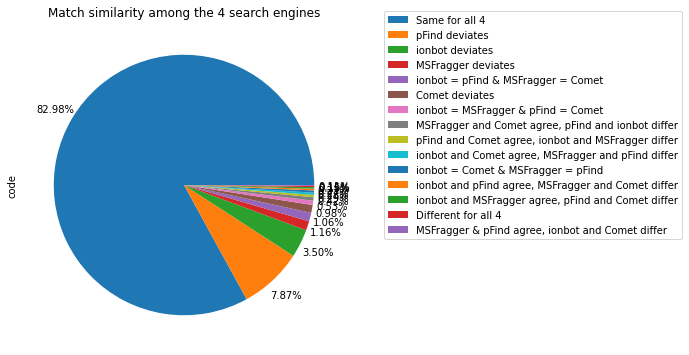

In [287]:
fig = plt.figure(figsize = (10,30))
ax = Allmatched["code"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%', pctdistance=1.15)
ax.set_title("Match similarity among the 4 search engines")
ax
ax.legend(bbox_to_anchor=(1.1, 1.05), labels=Allmatched["code"].value_counts().index)
fig.tight_layout()

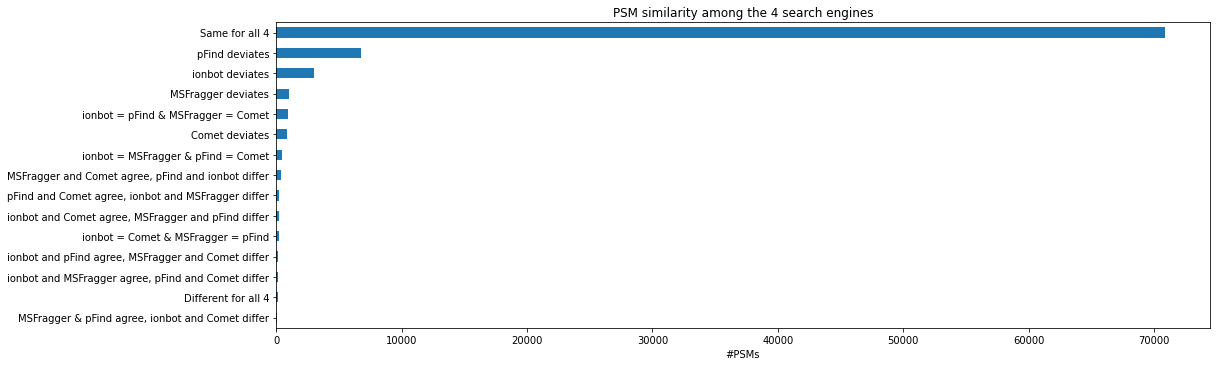

In [288]:
fig = plt.figure(figsize = (17,5))
ax = Allmatched["code"].value_counts().plot(kind="barh")
ax.set_title("PSM similarity among the 4 search engines")
ax.invert_yaxis()
fig.tight_layout()
plt.xlabel("#PSMs")
plt.show()

- Huge majority is the same PSM for all 4 search engines
- Interesting: you'd think Comet would deviate the most because most modifications can't be identified with Comet, but it actually deviates from the other three the least!

# Compare ionbot, MSFragger and pFind with Comet

## ionbot

In [289]:
#Get PSMs where ionbot differs from Comet
ionbotvcomet = Allmatched[Allmatched["code"].isin(["ionbot deviates", "MSFragger & pFind agree, ionbot and Comet differ", "Comet deviates", "ionbot = pFind & MSFragger = Comet", "pFind and Comet agree, ionbot and MSFragger differ", "ionbot and pFind agree, MSFragger and Comet differ", "Different for all 4", "ionbot = MSFragger & pFind = Comet", "MSFragger and Comet agree, pFind and ionbot differ", "ionbot and MSFragger agree, pFind and Comet differ"])]

In [290]:
ionbotvcomet.head()

,Unnamed: 0.1,Unnamed: 0,Spectrum File,Scan,ionbot Sequence,ionbot modifications,ionbot unexpected modifications,ionbot q-value,ionbot PEP,Fragger Sequence,...,pFindID,CometID,Fragger PEP,code,ionbot_seq_eval,fragger_seq_eval,pfind_seq_eval,ionbot_mods_eval,fragger_mods_eval,pfind_mods_eval
14,14,14,131023_Sunil_PPT_Brain_A_01,10259.0,LQGIVSWGSNCAQK,10|Gly->Asn[G],substitution,0.00296,0.00078,LQGIVSWGSGCAQK,...,10259.0LQGIVSWGSGCAQK['carbamidomethyl'],10259.0LQGIVSWGSGCAQK['carbamidomethyl'],0.0000,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications
20,20,20,131023_Sunil_PPT_Brain_A_01,10369.0,LQGIVSWGSNCAQK,10|Gly->Asn[G],substitution,0.00296,0.00066,LQGIVSWGSGCAQK,...,10369.0LQGIVSWGSGCAQK['carbamidomethyl'],10369.0LQGIVSWGSGCAQK['carbamidomethyl'],0.0002,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications
31,31,31,131023_Sunil_PPT_Brain_A_01,10513.0,GAGQGPITEDMLCAGYLEGER,x|[914]Methylmalonylation[S],[914]Methylmalonylation[S],0.00296,0.03493,SAYPGQITSNMFCAGYLEGGK,...,10513.0SAYPGQITSNMFCAGYLEGGK['carbamidomethyl'...,10513.0SAYPGQITSNMFCAGYLEGGK['carbamidomethyl'...,0.0023,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications
40,40,40,131023_Sunil_PPT_Brain_A_01,10677.0,LQGIVSWGSNCAQK,10|Gly->Asn[G],substitution,0.00296,0.01455,LQGIVSWGSGCAQK,...,10677.0LQGIVSWGSGCAQK['carbamidomethyl'],10677.0LQGIVSWGSGCAQK['carbamidomethyl'],0.0215,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications
51,51,51,131023_Sunil_PPT_Brain_A_01,10820.0,LQGIVSWGSNCAQK,10|Gly->Asn[G],substitution,0.00296,0.02879,LQGIVSWGSGCAQK,...,10820.0LQGIVSWGSGCAQK['carbamidomethyl'],10820.0LQGIVSWGSGCAQK['carbamidomethyl'],0.0266,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications


In [291]:
def which_is_it_then(row, ionbot=False, Fragger=False, pFind=False):
    if ionbot:
        if pd.isna(row["comet_mods_formatted"]):
            if not pd.isna(row["ionbot_mods_formatted"]):
                #Als comet geen modifications gaf en ionbot wel
                if row["ionbot Sequence"] == row["Comet Raw Sequence"]:
                    return "Same sequence, now with modification(s)"
                else:
                    return "Different sequence with modification(s)"
            else: #Als zowel Comet als ionbot geen modifications geven
                if row["ionbot Sequence"] == row["Comet Raw Sequence"]:
                    return "ERROR"
                else:
                    return "Different sequence (remains unmodified)"
        
        elif pd.isna(row["ionbot_mods_formatted"]):
            if not pd.isna(row["comet_mods_formatted"]):
                #Als ionbot geen modifications gaf en comet wel
                if row["ionbot Sequence"] == row["Comet Raw Sequence"]:
                    return "Same sequence, no longer modified"
                else:
                    return "Different sequence, not modified"
            else: #Als zowel ionbot en Comet geen modificaties geven
                if row["ionbot Sequence"] == row["Comet Raw Sequence"]:
                    return "ERROR"
                else:
                    return "Different sequence (remains unmodified)"

        else: #Als beide modificaties geven
            if row["ionbot Sequence"] == row["Comet Raw Sequence"]:
                if row["ionbot_mods_formatted"] == row["comet_mods_formatted"]:
                    return "ERROR"
                else:
                    return "Same sequence, different modifications"
            else:
                if row["ionbot_mods_formatted"] == row["comet_mods_formatted"]:
                    return "Different sequence, same modifications"
                else:
                    return "Different sequence, different modifications"
    
    elif Fragger:
        if pd.isna(row["comet_mods_formatted"]):
            if not pd.isna(row["fragger_mods_formatted"]):
                #Als comet geen modifications gaf en Fragger wel
                if row["Fragger Sequence"] == row["Comet Raw Sequence"]:
                    return "Same sequence, now with modification(s)"
                else:
                    return "Different sequence with modification(s)"
            else: #Als zowel Comet als Fragger geen modifications geven
                if row["Fragger Sequence"] == row["Comet Raw Sequence"]:
                    return "ERROR"
                else:
                    return "Different sequence (remains unmodified)"
        
        elif pd.isna(row["fragger_mods_formatted"]):
            if not pd.isna(row["comet_mods_formatted"]):
                #Als Fragger geen modifications gaf en comet wel
                if row["Fragger Sequence"] == row["Comet Raw Sequence"]:
                    return "Same sequence, no longer modified"
                else:
                    return "Different sequence, not modified"
            else: #Als zowel Fragger en Comet geen modificaties geven
                if row["Fragger Sequence"] == row["Comet Raw Sequence"]:
                    return "ERROR"
                else:
                    return "Different sequence (remains unmodified)"

        else: #Als beide modificaties geven
            if row["Fragger Sequence"] == row["Comet Raw Sequence"]:
                if row["fragger_mods_formatted"] == row["comet_mods_formatted"]:
                    return "ERROR"
                else:
                    return "Same sequence, different modifications"
            else:
                if row["fragger_mods_formatted"] == row["comet_mods_formatted"]:
                    return "Different sequence, same modifications"
                else:
                    return "Different sequence, different modifications"

    elif pFind:
        if pd.isna(row["comet_mods_formatted"]):
            if not pd.isna(row["pfind_mods_formatted"]):
                #Als comet geen modifications gaf en pFind wel
                if row["pFind Sequence"] == row["Comet Raw Sequence"]:
                    return "Same sequence, now with modification(s)"
                else:
                    return "Different sequence with modification(s)"
            else: #Als zowel Comet als pFind geen modifications geven
                if row["pFind Sequence"] == row["Comet Raw Sequence"]:
                    return "ERROR"
                else:
                    return "Different sequence (remains unmodified)"
        
        elif pd.isna(row["pfind_mods_formatted"]):
            if not pd.isna(row["comet_mods_formatted"]):
                #Als pFind geen modifications gaf en comet wel
                if row["pFind Sequence"] == row["Comet Raw Sequence"]:
                    return "Same sequence, no longer modified"
                else:
                    return "Different sequence, not modified"
            else: #Als zowel pFind en Comet geen modificaties geven
                if row["pFind Sequence"] == row["Comet Raw Sequence"]:
                    return "ERROR"
                else:
                    return "Different sequence (remains unmodified)"

        else: #Als beide modificaties geven
            if row["pFind Sequence"] == row["Comet Raw Sequence"]:
                if row["pfind_mods_formatted"] == row["comet_mods_formatted"]:
                    return "ERROR"
                else:
                    return "Same sequence, different modifications"
            else:
                if row["pfind_mods_formatted"] == row["comet_mods_formatted"]:
                    return "Different sequence, same modifications"
                else:
                    return "Different sequence, different modifications"

In [292]:
ionbotvcomet["Evaluation"] = ionbotvcomet.progress_apply(which_is_it_then, ionbot=True, axis=1)

100%|██████████| 6353/6353 [00:00<00:00, 16915.05it/s]


In [293]:
ionbotvcomet.head()

,Unnamed: 0.1,Unnamed: 0,Spectrum File,Scan,ionbot Sequence,ionbot modifications,ionbot unexpected modifications,ionbot q-value,ionbot PEP,Fragger Sequence,...,CometID,Fragger PEP,code,ionbot_seq_eval,fragger_seq_eval,pfind_seq_eval,ionbot_mods_eval,fragger_mods_eval,pfind_mods_eval,Evaluation
14,14,14,131023_Sunil_PPT_Brain_A_01,10259.0,LQGIVSWGSNCAQK,10|Gly->Asn[G],substitution,0.00296,0.00078,LQGIVSWGSGCAQK,...,10259.0LQGIVSWGSGCAQK['carbamidomethyl'],0.0000,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications,"Different sequence, different modifications"
20,20,20,131023_Sunil_PPT_Brain_A_01,10369.0,LQGIVSWGSNCAQK,10|Gly->Asn[G],substitution,0.00296,0.00066,LQGIVSWGSGCAQK,...,10369.0LQGIVSWGSGCAQK['carbamidomethyl'],0.0002,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications,"Different sequence, different modifications"
31,31,31,131023_Sunil_PPT_Brain_A_01,10513.0,GAGQGPITEDMLCAGYLEGER,x|[914]Methylmalonylation[S],[914]Methylmalonylation[S],0.00296,0.03493,SAYPGQITSNMFCAGYLEGGK,...,10513.0SAYPGQITSNMFCAGYLEGGK['carbamidomethyl'...,0.0023,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications,"Different sequence, different modifications"
40,40,40,131023_Sunil_PPT_Brain_A_01,10677.0,LQGIVSWGSNCAQK,10|Gly->Asn[G],substitution,0.00296,0.01455,LQGIVSWGSGCAQK,...,10677.0LQGIVSWGSGCAQK['carbamidomethyl'],0.0215,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications,"Different sequence, different modifications"
51,51,51,131023_Sunil_PPT_Brain_A_01,10820.0,LQGIVSWGSNCAQK,10|Gly->Asn[G],substitution,0.00296,0.02879,LQGIVSWGSGCAQK,...,10820.0LQGIVSWGSGCAQK['carbamidomethyl'],0.0266,ionbot deviates,False,True,True,Different modifications,Same modifications,Same modifications,"Different sequence, different modifications"


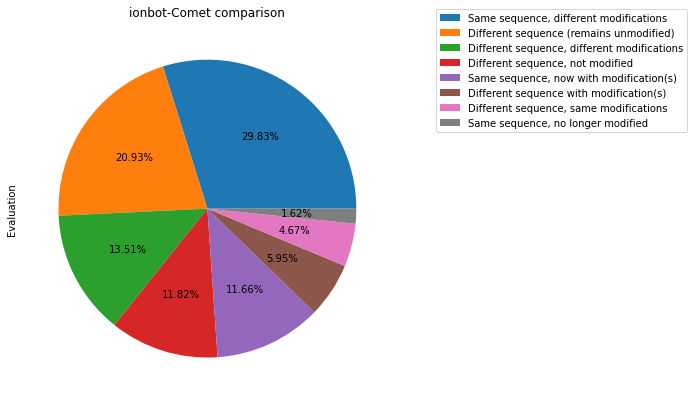

In [294]:
fig = plt.figure(figsize = (10,50))
ax = ionbotvcomet["Evaluation"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%')
ax.set_title("ionbot-Comet comparison")
ax.legend(bbox_to_anchor=(1.1, 1.05), labels=ionbotvcomet["Evaluation"].value_counts().index)
fig.tight_layout()

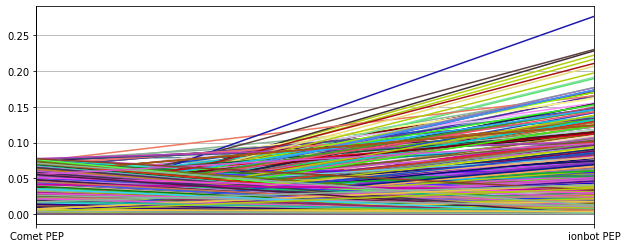

In [295]:
fig, ax = plt.subplots(figsize=(10,4))
parallel_coordinates(ionbotvcomet,"ionbot Sequence",["Comet PEP", "ionbot PEP"])
ax.legend_.remove()

Doesn't look great, if you see boxplots you see that box is lower than Comet but way more extreme outliers which is reflected here

In [296]:
res = stats.wilcoxon(x=ionbotvcomet["Comet PEP"], y=ionbotvcomet["ionbot PEP"], alternative='greater', nan_policy="raise")
print(res)

WilcoxonResult(statistic=14722632.0, pvalue=1.6427580194248704e-220)


## Fragger

In [297]:
#Filter PSMs where Comet and MSFragger differ
fraggervcomet = Allmatched[Allmatched["code"].isin(["MSFragger deviates", "pFind and Comet agree, ionbot and MSFragger differ", "Comet deviates", "ionbot and pFind agree, MSFragger and Comet differ", "ionbot and Comet agree, MSFragger and pFind differ", "ionbot = MSFragger & pFind = Comet", "Different for all 4", "ionbot = Comet & MSFragger = pFind", "ionbot and MSFragger agree, pFind and Comet differ", "MSFragger & pFind agree, ionbot and Comet differ"])]

In [298]:
fraggervcomet["Evaluation"] = fraggervcomet.progress_apply(which_is_it_then, Fragger = True, axis=1)

100%|██████████| 3560/3560 [00:00<00:00, 16392.63it/s]


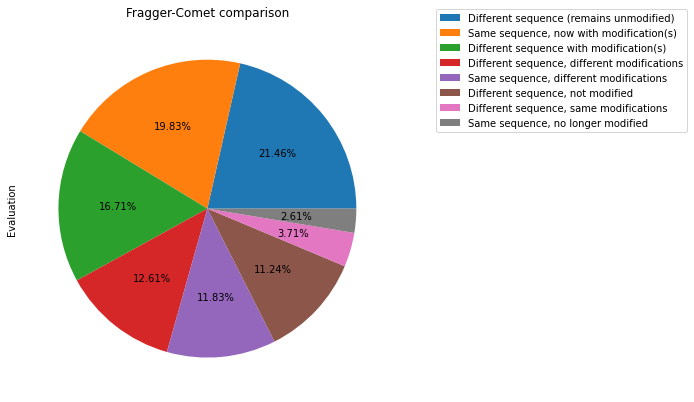

In [299]:
fig = plt.figure(figsize = (10,50))
ax = fraggervcomet["Evaluation"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%')
ax.set_title("Fragger-Comet comparison")
ax.legend(bbox_to_anchor=(1.1, 1.05), labels=fraggervcomet["Evaluation"].value_counts().index)
fig.tight_layout()

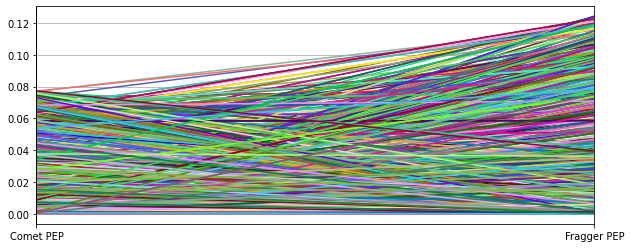

In [300]:
fig, ax = plt.subplots(figsize=(10,4))
parallel_coordinates(fraggervcomet,"Fragger Sequence",["Comet PEP", "Fragger PEP"])
ax.legend_.remove()

In [301]:
res = stats.wilcoxon(x=fraggervcomet["Comet PEP"], y=fraggervcomet["Fragger PEP"], alternative="less")
print(res)

WilcoxonResult(statistic=2779635.0, pvalue=1.0532155592551237e-10)


LESS GOOD!!

## pFind

Oke dus geen PEP voor pFind ==> alles behalve de paired test

Daarna: filter PSMs op zij die verschillen tussen ionbot, Fragger en Comet en doe dan ook zo een grafiek gelijk bij accuracy_check

Daarna: mss niet filteren en echt alle PSMs checken (checkt ook of PEP-test relevant is)

In [302]:
#Filter PSMs where Comet and pFind differ
pfindvcomet = Allmatched[Allmatched["code"].isin(["pFind deviates","Comet deviates", "ionbot and pFind agree, MSFragger and Comet differ", "Different for all 4", "ionbot and MSFragger agree, pFind and Comet differ", "MSFragger & pFind agree, ionbot and Comet differ", "ionbot = pFind & MSFragger = Comet", "ionbot and Comet agree, MSFragger and pFind differ", "MSFragger and Comet agree, pFind and ionbot differ", "ionbot = Comet & MSFragger = pFind"])]

In [303]:
pfindvcomet["Evaluation"] = pfindvcomet.progress_apply(which_is_it_then, pFind=True, axis=1)

100%|██████████| 9862/9862 [00:00<00:00, 21410.96it/s]


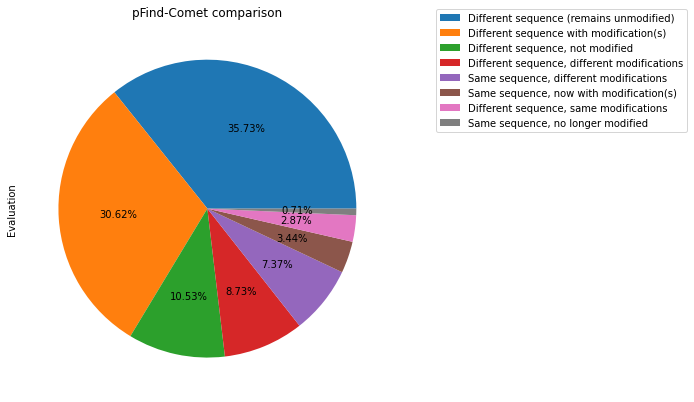

In [304]:
fig = plt.figure(figsize = (10,50))
ax = pfindvcomet["Evaluation"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%')
ax.set_title("pFind-Comet comparison")
ax.legend(bbox_to_anchor=(1.1, 1.05), labels=pfindvcomet["Evaluation"].value_counts().index)
fig.tight_layout()

## Combine the which is it then plots

In [305]:
colors={'Same sequence, different modifications': 'cyan',
'Different sequence (remains unmodified)': "orange",
"Different sequence, different modifications": "purple",
"Different sequence, not modified" : "red",
'Same sequence, now with modification(s)' : "brown",
'Different sequence with modification(s)' : "pink",
'Different sequence, same modifications':"green",
"Same sequence, no longer modified": "grey"}

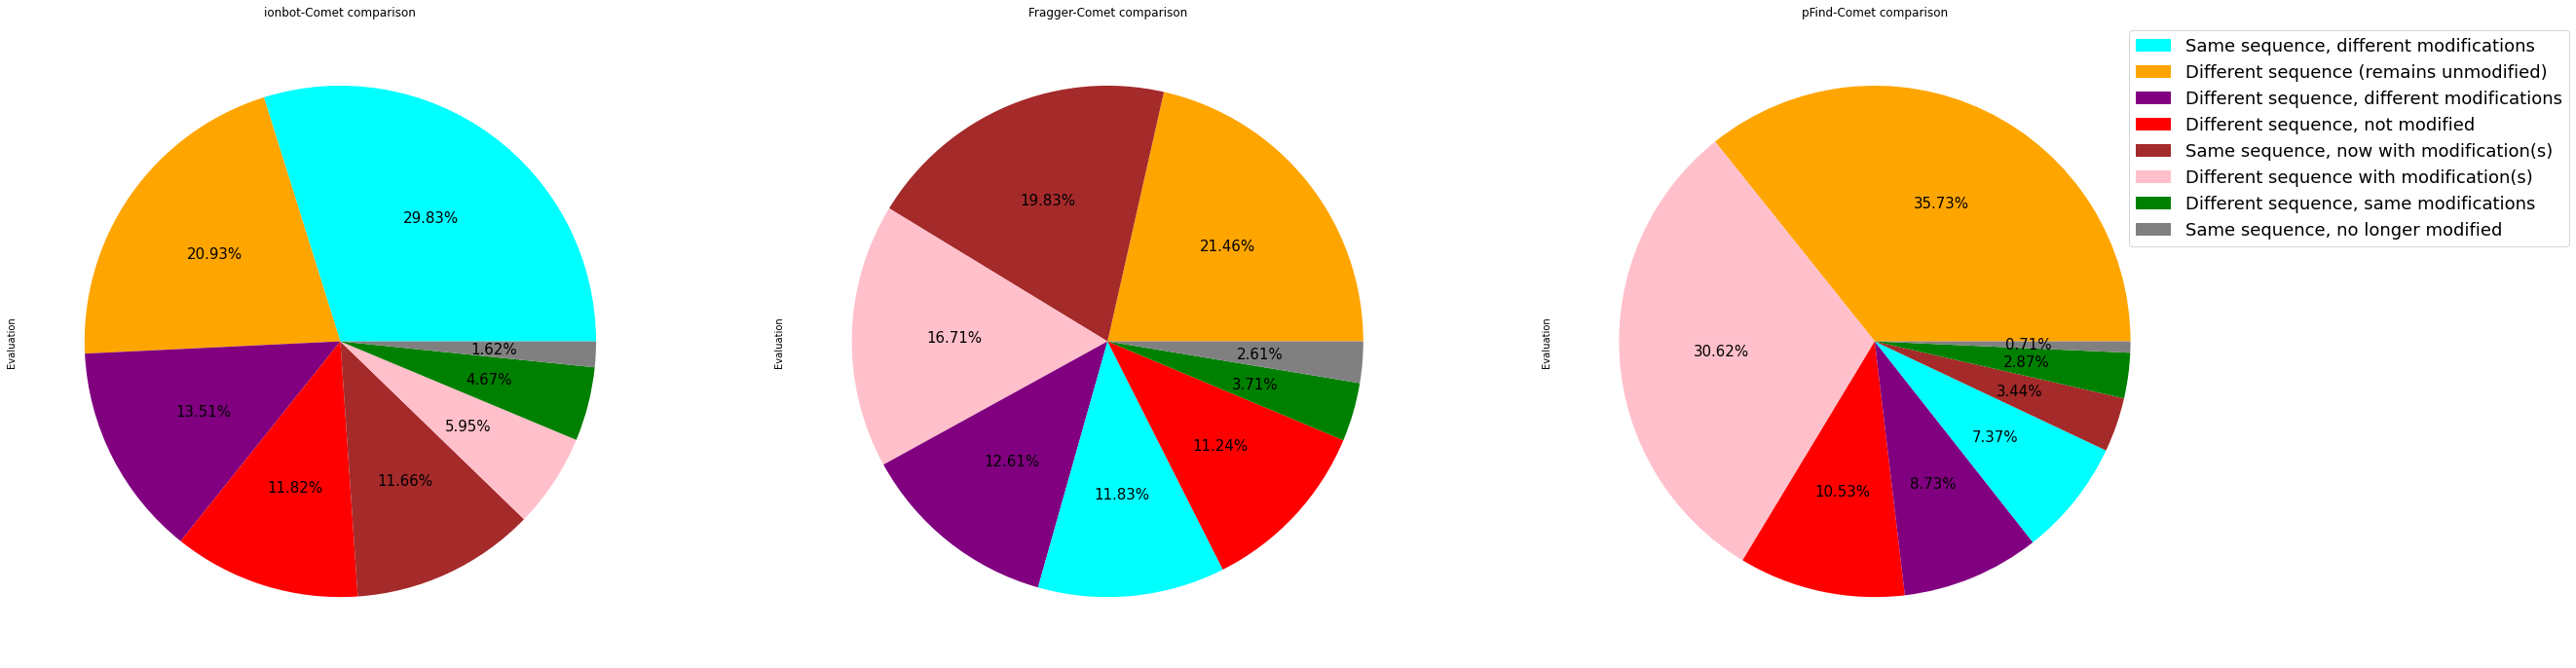

In [306]:
fig, ax = plt.subplots(1,3)
ax1 = ionbotvcomet["Evaluation"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%', ax=ax[0], colors=[colors[v] for v in ionbotvcomet["Evaluation"].value_counts().keys()], fontsize=15)
ax1.set_title("ionbot-Comet comparison")
ax2 = fraggervcomet["Evaluation"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%', ax=ax[1], colors=[colors[v] for v in fraggervcomet["Evaluation"].value_counts().keys()], fontsize=15)
ax2.set_title("Fragger-Comet comparison")
ax3 = pfindvcomet["Evaluation"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%', ax=ax[2], colors=[colors[v] for v in pfindvcomet["Evaluation"].value_counts().keys()], fontsize=15)
ax3.set_title("pFind-Comet comparison")
ax1.legend(labels = ionbotvcomet["Evaluation"].value_counts().keys(), bbox_to_anchor=(4,1), prop={'size': 18})
fig.set_size_inches(40,50)


- quite different between all three
- counter-intuitively, a lot of the changes is different sequence with no change in modifications, or even with less modifications than closed search PSM (okergeel, rood, grijs)
- ionbot identifies same sequence, different modifications a lot, which makes sense, but others don't do this as much (the PSMs where this happens are also most of the time where ionbot deviates)
- Fragger identifies, same sequence, now with modifications a lot, which makes sense, but others don't do this as much ==> if you check these, this is always a very small modification added (makes sense), like deamidation, amidation, other mods wiht mass of +/- 1 m/z 

# PEP comparison for the scans where ionbot, MSFragger and Comet PSMs are different

In [307]:
#Scans where ionbot, pFind and Comet differ
PEPcheck = Allmatched[Allmatched["code"].isin(["ionbot and pFind agree, MSFragger and Comet differ", "Different for all 4", "MSFragger & pFind agree, ionbot and Comet differ", "pFind and Comet agree, ionbot and MSFragger differ"])]

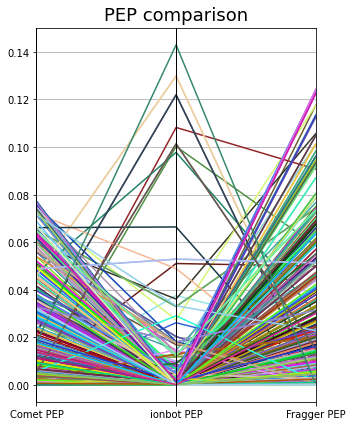

In [308]:
fig, ax = plt.subplots(figsize=(5,6))
parallel_coordinates(PEPcheck,"Scan",["Comet PEP", "ionbot PEP", "Fragger PEP"])
plt.suptitle("PEP comparison", size=18)
ax.legend_.remove()
fig.tight_layout()
fig.subplots_adjust(top=0.93)

# PEP check for spectra where PSMs of ionbot, Fragger and Comet are the same (validation)

In [309]:
#Scans where PSMs of ionbot, Fragger, Comet are the same
PEPcheckval = Allmatched[Allmatched["code"].isin(["Same for all 4", "pFind deviates"])]
#Get sample (if you don't theres too many rows in parallel coordinates plot, which makes it hard to discern pattern)
PEPcheckval_sample = PEPcheckval.sample(1000)

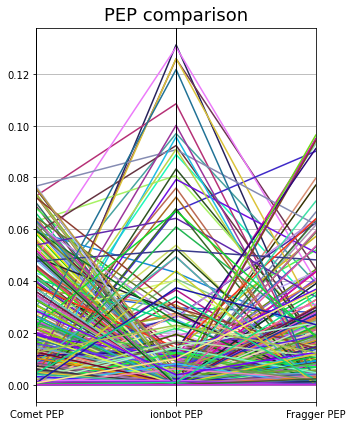

In [310]:
fig, ax = plt.subplots(figsize=(5,6))
parallel_coordinates(PEPcheckval_sample,"Scan",["Comet PEP", "ionbot PEP", "Fragger PEP"])
plt.suptitle("PEP comparison", size=18)
ax.legend_.remove()
fig.tight_layout()
fig.subplots_adjust(top=0.93)

In [311]:
stats.kruskal(PEPcheckval["Comet PEP"], PEPcheckval["ionbot PEP"], PEPcheckval["Fragger PEP"])

KruskalResult(statistic=14667.321906346206, pvalue=0.0)

Post-hoc:

In [312]:
sp.posthoc_dunn([PEPcheckval["Comet PEP"], PEPcheckval["ionbot PEP"], PEPcheckval["Fragger PEP"]], p_adjust="bonferroni")

,1,2,3
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0


<AxesSubplot:>

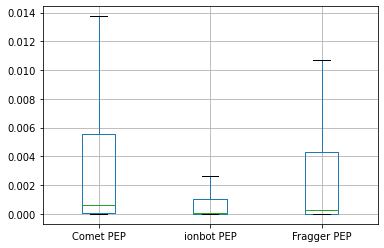

In [313]:
PEPcheckval[["Comet PEP","ionbot PEP","Fragger PEP"]].boxplot(showfliers=False)

Bin PEP's for each Search engine?  And then compare the bins in which the PSMs are found?

## Binning?

In [314]:
Allmatched["ionbot PEP binned"] = pd.cut(Allmatched["ionbot PEP"], bins=(0, 0.01405, 0.0281, 0.04215, 0.0562, 0.07025, 0.0843, 0.09835, 0.1124, 0.12645, 0.1405, 0.15455, 0.1686,0.18265,0.1967,0.21075,0.2248,0.23885,0.2529,0.26695,0.281), labels=[i+1 for i in range(20)], include_lowest=True)

In [315]:
Allmatched["Fragger PEP binned"] = pd.cut(Allmatched["Fragger PEP"], bins=(0, 0.00625, 0.0125, 0.01875, 0.025, 0.03125, 0.0375, 0.04375, 0.05, 0.05625, 0.0625, 0.06875, 0.075, 0.08125,0.0875,0.09375,0.1,0.10625,0.1125,0.11875,0.125), labels=[i+1 for i in range(20)], include_lowest=True)

In [316]:
Allmatched["Comet PEP binned"] = pd.cut(Allmatched["Comet PEP"], bins=(0,0.00385,0.0077,0.01155,0.0154,0.01925,0.0231,0.02695,0.0308,0.03465,0.0385,0.04235,0.0462,0.05005,0.0539,0.05775,0.0616,0.06545,0.0693,0.07315,0.077), labels=[i+1 for i in range(20)], include_lowest=True)

In [317]:
PEPcheckval_bin = Allmatched[Allmatched["code"].isin(["Same for all 4", "pFind deviates"])]
PEPcheckval_sample_bin = PEPcheckval_bin.sample(1000)

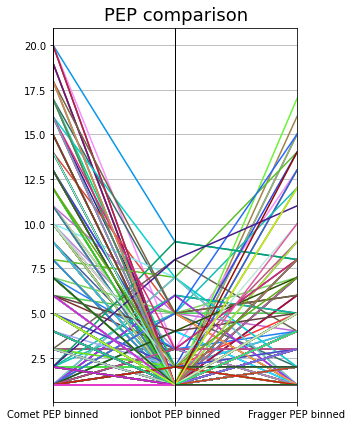

In [318]:
fig, ax = plt.subplots(figsize=(5,6))
parallel_coordinates(PEPcheckval_sample_bin,"Scan",["Comet PEP binned", "ionbot PEP binned", "Fragger PEP binned"])
plt.suptitle("PEP comparison", size=18)
ax.legend_.remove()
fig.tight_layout()
fig.subplots_adjust(top=0.93)

## Upsetplots

In [319]:
PXD002516.head()

,Unnamed: 0.1,Unnamed: 0,Spectrum File,Scan,ionbot Sequence,ionbot modifications,ionbot unexpected modifications,ionbot q-value,ionbot PEP,Fragger Sequence,...,pFindID,CometID,Fragger PEP,code,ionbot_seq_eval,fragger_seq_eval,pfind_seq_eval,ionbot_mods_eval,fragger_mods_eval,pfind_mods_eval
0,0,0,131023_Sunil_PPT_Brain_A_01,10006.0,LAVNMVPFPR,5|[35]oxidation[M],NaN,0.00296,0.22551,LAVNMVPFPR,...,10006.0LAVNMVPFPR['oxidation'],NaN,0.0479,1110-110100,False,False,False,Newly modified,Newly modified,Newly modified
1,1,1,131023_Sunil_PPT_Brain_A_01,10011.0,TYFPHFDLSHGSAQVK,NaN,NaN,0.00296,0.14552,TYFPHFDLSHGSAQVK,...,10011.0TYFPHFDLSHGSAQVKnan,NaN,0.0003,1110-110100,False,False,False,Remains unmodified,Remains unmodified,Remains unmodified
2,2,2,131023_Sunil_PPT_Brain_A_01,10039.0,LQGIVSWGSGCAQK,11|[4]carbamidomethyl[C],NaN,0.00296,0.00027,LQGIVSWGSGCAQK,...,10039.0LQGIVSWGSGCAQK['carbamidomethyl'],10039.0LQGIVSWGSGCAQK['carbamidomethyl'],0.0000,1111-111111,True,True,True,Same modifications,Same modifications,Same modifications
3,3,3,131023_Sunil_PPT_Brain_A_01,10045.0,TYFPHFDLSHGSAQVK,NaN,NaN,0.00296,0.13579,TYFPHFDLSHGSAQVK,...,10045.0TYFPHFDLSHGSAQVKnan,NaN,0.0027,1110-110100,False,False,False,Remains unmodified,Remains unmodified,Remains unmodified
4,4,4,131023_Sunil_PPT_Brain_A_01,10051.0,IFLQDIK,NaN,NaN,0.00296,0.09598,IFLQDIK,...,10051.0IFLQDIKnan,NaN,0.0453,1110-110100,False,False,False,Remains unmodified,Remains unmodified,Remains unmodified


## All scans taken into account

In [320]:
ionbot = list(set(PXD002516["ionbotID"]))
fragger = list(set(PXD002516["FraggerID"]))
pfind = list(set(PXD002516["pFindID"]))
comet = list(set(PXD002516["CometID"]))

In [321]:
allscans = upsetplot.from_contents({'ionbot': ionbot, 'MSFragger': fragger, 'pFind': pfind, 'Comet': comet})

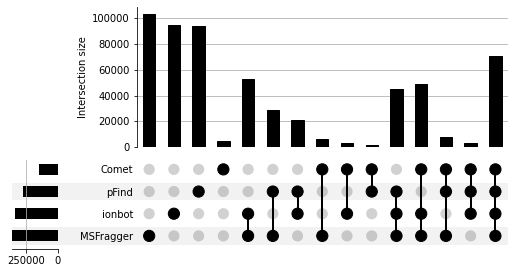

In [322]:
ax_dict = upsetplot.UpSet(allscans, subset_size="count").plot()

## Only scans were all 4 search engines make a PSM

In [323]:
ionbotAllmatched = list(set(Allmatched["ionbotID"]))
fraggerAllmatched = list(set(Allmatched["FraggerID"]))
pfindAllmatched = list(set(Allmatched["pFindID"]))
cometAllmatched = list(set(Allmatched["CometID"]))

In [324]:
allmatchedplot = upsetplot.from_contents({'ionbot':ionbotAllmatched, 'MSFragger': fraggerAllmatched, "pFind":pfindAllmatched, "Comet":cometAllmatched })

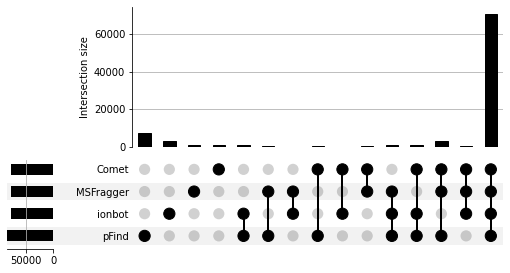

In [325]:
ax_dict = upsetplot.UpSet(allmatchedplot, subset_size="count").plot()

## Evaluation should go in bar plot

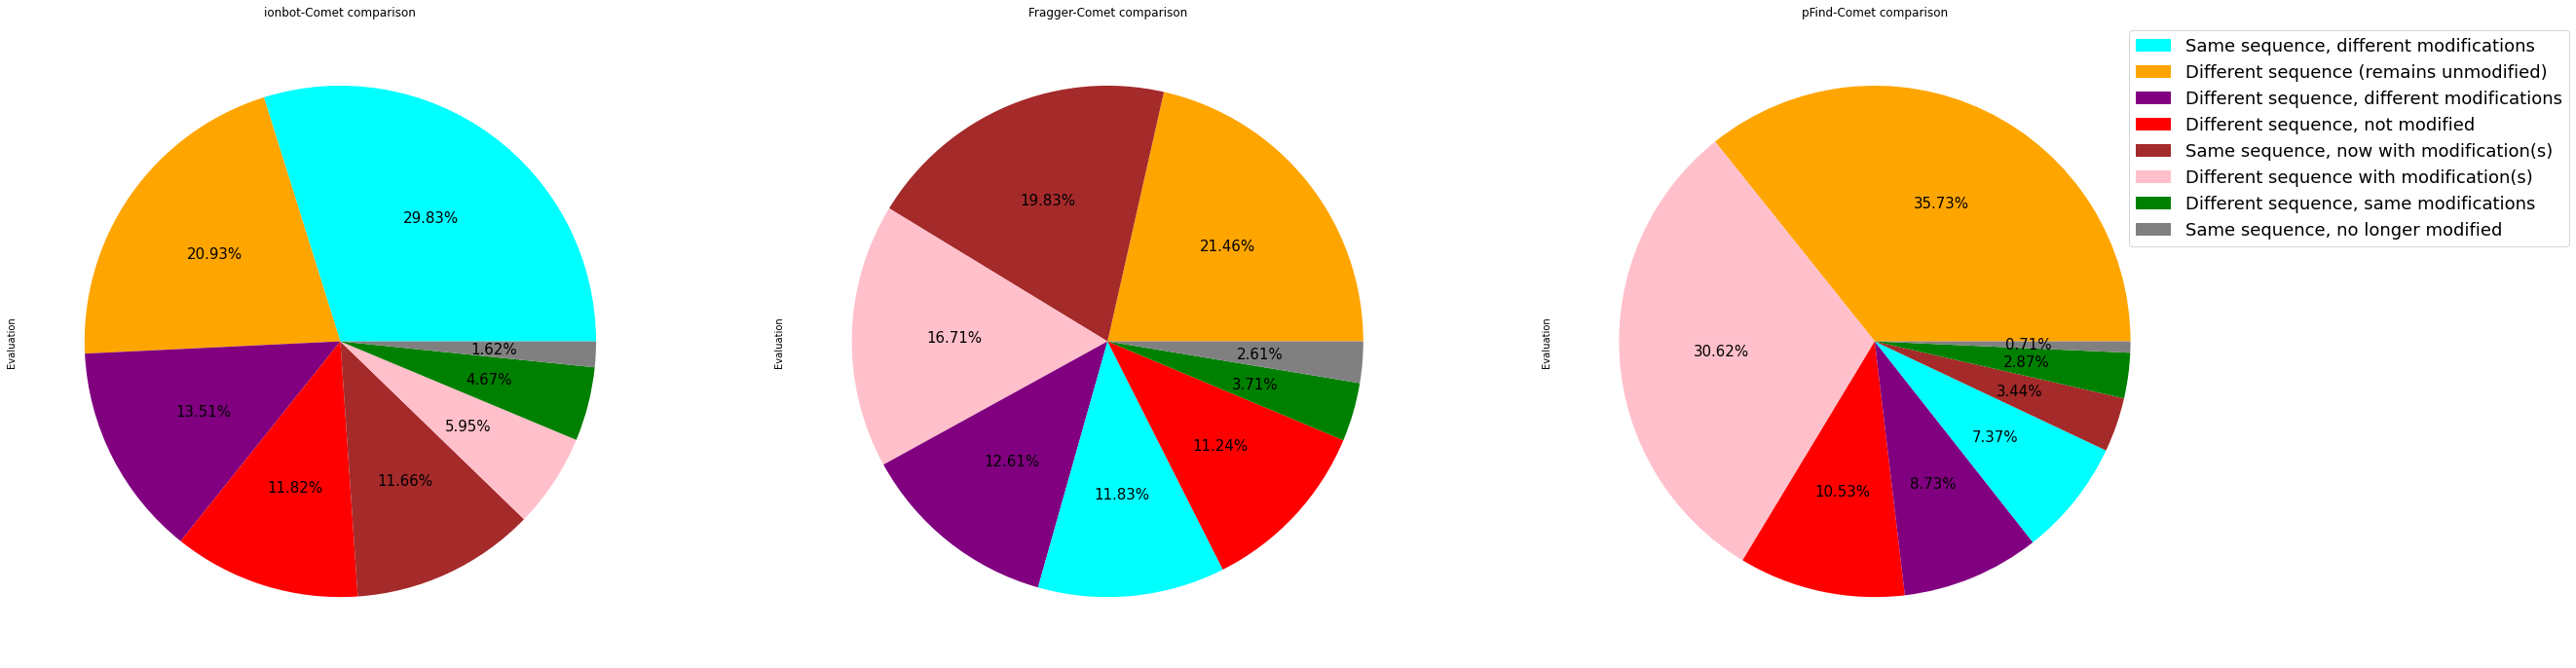

In [326]:
fig, ax = plt.subplots(1,3)
ax1 = ionbotvcomet["Evaluation"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%', ax=ax[0], colors=[colors[v] for v in ionbotvcomet["Evaluation"].value_counts().keys()], fontsize=15)
ax1.set_title("ionbot-Comet comparison")
ax2 = fraggervcomet["Evaluation"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%', ax=ax[1], colors=[colors[v] for v in fraggervcomet["Evaluation"].value_counts().keys()], fontsize=15)
ax2.set_title("Fragger-Comet comparison")
ax3 = pfindvcomet["Evaluation"].value_counts().plot(kind="pie", labels=None, autopct='%1.2f%%', ax=ax[2], colors=[colors[v] for v in pfindvcomet["Evaluation"].value_counts().keys()], fontsize=15)
ax3.set_title("pFind-Comet comparison")
ax1.legend(labels = ionbotvcomet["Evaluation"].value_counts().keys(), bbox_to_anchor=(4,1), prop={'size': 18})
fig.set_size_inches(40,50)

In [361]:
PXD002516.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Spectrum File', 'Scan',
       'ionbot Sequence', 'ionbot modifications',
       'ionbot unexpected modifications', 'ionbot q-value', 'ionbot PEP',
       'Fragger Sequence', 'Fragger Modified Sequence', 'Fragger Probability',
       'Fragger modifications', 'Fragger unexpected modifications',
       'MSFragger Localization', 'pFind Sequence', 'pFind Modification',
       'pFind q-value', 'Comet Sequence', 'Comet q-value', 'Comet PEP',
       'Comet Raw Sequence', 'ionbot_mods_formatted', 'all_fragger_mods',
       'fragger_mods_formatted', 'pfind_mods_formatted',
       'comet_mods_formatted', 'ionbotID', 'FraggerID', 'pFindID', 'CometID',
       'Fragger PEP', 'code', 'ionbot_seq_eval', 'fragger_seq_eval',
       'pfind_seq_eval', 'ionbot_mods_eval', 'fragger_mods_eval',
       'pfind_mods_eval'],
      dtype='object')

In [362]:
ionbotvcomet.shape[0]

6353

In [363]:
ionbotwhich = ionbotvcomet.groupby(["ionbot_seq_eval", "ionbot_mods_eval"])["ionbotID"].count()
fraggerwhich = fraggervcomet.groupby(["fragger_seq_eval", "fragger_mods_eval"])["FraggerID"].count()
pfindwhich = pfindvcomet.groupby(["pfind_seq_eval", "pfind_mods_eval"])["pFindID"].count()

Maak met die data bar plots ala powerpoint

In [364]:
iw = ionbotwhich.reset_index()
fw = fraggerwhich.reset_index()
pw = pfindwhich.reset_index()

In [365]:
fw

,fragger_seq_eval,fragger_mods_eval,FraggerID
0,False,Different modifications,449
1,False,Newly modified,595
2,False,No longer modified,400
3,False,Remains unmodified,764
4,False,Same modifications,132
5,True,Different modifications,421
6,True,Newly modified,706
7,True,No longer modified,93


In [366]:
iw["Relative occurrence"] = (iw["ionbotID"] /iw["ionbotID"].sum()).round(3)
fw["Relative occurrence"] = (fw["FraggerID"] /fw["FraggerID"].sum()).round(3)
pw["Relative occurrence"] = (pw["pFindID"]/pw["pFindID"].sum()).round(3)

In [367]:
iw.rename(columns={"ionbotID":"ID", "ionbot_mods_eval":"ModsEval", "ionbot_seq_eval":"SeqEval"}, inplace=True)
fw.rename(columns={"FraggerID":"ID", "fragger_mods_eval":"ModsEval", "fragger_seq_eval":"SeqEval"}, inplace=True)
pw.rename(columns={"pFindID":"ID", "pfind_mods_eval": "ModsEval", "pfind_seq_eval":"SeqEval"}, inplace=True)


In [368]:
iw["Relative occurrence"].sum()

0.9989999999999999

In [369]:
iw["SE"] = "ionbot"
fw["SE"] = "fragger"
pw["SE"] = "pfind"

In [370]:
data = pd.concat([iw, fw, pw])

In [371]:
seqevaltrue = data[data["SeqEval"] == True]
seqevalfalse = data[data["SeqEval"] == False]

In [372]:
data["Relative occurrence"].sum()

2.997

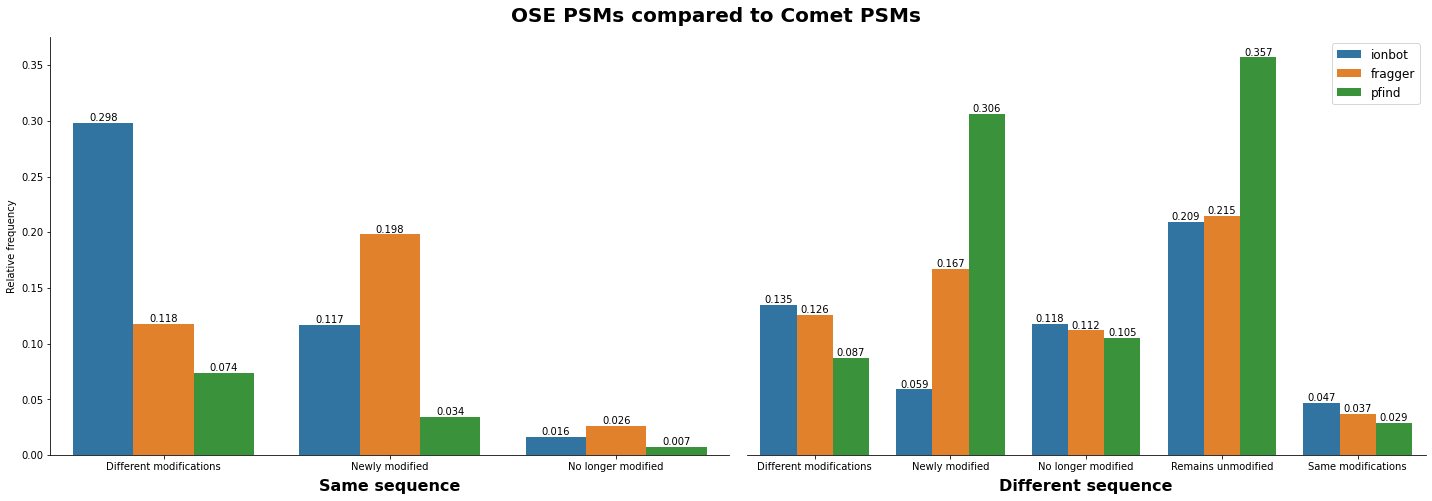

In [423]:
fig, axes = plt.subplots(1,2,sharey=True, figsize=(20,7))
a = sns.barplot(data=seqevaltrue, x="ModsEval", y="Relative occurrence", hue="SE", ax=axes[0])
b = sns.barplot(data = seqevalfalse, x="ModsEval", y="Relative occurrence", hue="SE", ax=axes[1])
axes[0].set_ylabel("Relative frequency")
axes[1].set_ylabel("Relative frequency")
axes[1].yaxis.set_tick_params(labelbottom=True)
axes[0].xaxis.label.set_visible(False)
axes[1].xaxis.label.set_visible(False)
axes[0].set_title("Same sequence", fontweight="bold", fontsize=16, y=-.10)
axes[1].set_title("Different sequence", fontweight="bold", fontsize=16, y=-0.10)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

#axes[0].spines['bottom'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
#axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)
# axes[1].axes.get_yaxis().set_ticks([])
axes[1].axes.get_yaxis().set_visible(False)
axes[0].get_legend().remove()
for container in axes[0].containers:
    axes[0].bar_label(container)
for container in axes[1].containers:
    axes[1].bar_label(container)
plt.legend(loc=1, prop={'size': 12})
fig.suptitle("OSE PSMs compared to Comet PSMs", fontsize=20, fontweight="bold")
fig.tight_layout()